# Übung 1 - Aufgabe 1 - Erkennung von Mode

Wird eine neue Programmiersprache erlernt, so beginnt man meistens mit einem *Hello World*. Im Bereich der KI bzw. des maschinellen Lernens wird gerne der *[MNIST Datensatz](https://de.wikipedia.org/wiki/MNIST-Datenbank)* als Beispiel verwendet. In dieser Aufgabe soll der sehr ähnlich aufgebaute *[Fashion-MNIST-Datensatz](https://github.com/zalandoresearch/fashion-mnist)* verwendet werden, um Modeartikel zu kategorisieren.

Diese Aufgabe ist folgendermaßen aufgebaut:

1. Vornehmen nötiger Imports
2. Laden der Daten
3. Aufbau des neuronalen Netzes
4. Anlegen des neuronalen Netzes und der Trainingsumgebung
5. Training und Test des neuronalen Netzes

Sie werden im Verlauf Ihrer KI-Karriere sehr schnell feststellen, dass nahezu alle Projekte im maschinellen Lernen (mit Ergänzung weiterer Datenvorverarbeitung) diesen groben Aufbau verfolgen. Nehmen Sie bitte die nötigen Ergänzungen in den Zellen vor. Zum Experimentieren können Sie auch gerne weitere Codezellen hinzufügen.

## 1. Nötige Imports vornehmen

Die folgende Code-Zelle importiert die notwendigen Bibliotheken, die im Folgenden benötigt werden.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## 2. Trainingsdaten laden

Zunächst werden die Trainingsdaten aus dem Internet geladen:

In [2]:
train_set = datasets.FashionMNIST(root="", train=True, transform=transforms.ToTensor(), download=True)
test_set = datasets.FashionMNIST(root="", train=False, transform=transforms.ToTensor(), download=True)

Am Anfang sollen nur die ersten 500 Datensätze der Trainingsdaten ausgewählt werden. Damit geht das Training deutlich schneller, aber dieses Vorgehen hat auch Nachteile.

In [3]:
N = 500
train_set.data = train_set.data[0:500] # Hier die ersten 500 Datensätze der Traningsdaten auswählen

### 2.1. "Form" der Trainingsdaten betrachten

Es wird nun die Form der Traningsdaten betrachtet. Haben Sie die vorherige Zelle korrekt ergänzt, so sollten Sie folgende Ausgabe erhalten:

```
train_set shape:  torch.Size([500, 28, 28])
test_set shape:  torch.Size([10000, 28, 28])
```

Machen Sie sich nun bitte klar, was die Zahlen bedeuten.

In [4]:
print("train_set shape: ", train_set.data.shape)
print("test_set shape: ", test_set.data.shape)

train_set shape:  torch.Size([500, 28, 28])
test_set shape:  torch.Size([10000, 28, 28])


Die Daten werden nun einem Data Loader übergeben, welcher eine Zufallsverteilung und eine Organisation in "batches" vornimmt.

In [5]:
train_loader = DataLoader(train_set, batch_size=64, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, pin_memory=True, shuffle=True)

### 2.2. Trainingsbeispiele ansehen

Die folgende Zelle lädt die ersten Trainingsdaten und zeigt ein paar Beispiele für verschiedene Klassen an. 

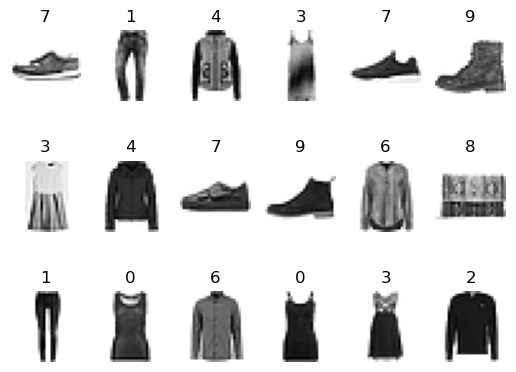

In [6]:
for images, labels in train_loader:
    # Erste Batch von Daten laden
    break
    
figure = plt.figure()
num_images = 18
for i in range(num_images):
    plt.subplot(3, 6, i+1, title=f"{labels[i]}")
    plt.axis("off")
    plt.imshow(images[i].cpu().numpy().squeeze(), cmap="gray_r")

## 3. Aufbau des neuronalen Netzes

Jetzt wird das neuronale Netz definiert. Zunächst soll mit folgendem einfachen Aufbau begonnen werden:

- Eine Eigabeschicht, die die $28 \cdot 28$ Pixel auf eine **versteckte Schicht** abbildet.
  Diese versteckte Schicht hat `hidden_size` Neuronen. Es wird mit zwei Neuronen 
  (`hidden_size = 2`) begonnen. 
- Die Eingabeschicht verwendet als **Aktivierungsfunktion** die 
  *[Rectified Linear Unit (ReLU)](https://de.wikipedia.org/wiki/Rectifier_(neuronale_Netzwerke))*
- Eine **Ausgabeschicht**, die für jede mögliche Ziffer ein Neuron enthält.
  Hier wird keine Aktivierungsfunktion benötigt – das am "stärksten feuernde" Neuron gewinnt am Ende
  bzw. die Werte werden automatisch so normiert, dass sie zwischen $0$ und $1$ liegen und in der Summe 
  $1$ ergeben ([Softmax](https://de.wikipedia.org/wiki/Softmax-Funktion)).
  
Zur Definition des Netzes wird eine Funktion `__init__()` zur Initialisierung der Layer und eine 
Funktion `forward()` die Rechenschritte des Netzes ausführt benötigt. Den ganzen mathematischen Rest erledigt die Bibliothek *PyTorch*. Bitte ergänzen Sie die genannte Definion in der Klasse ANN:

In [9]:
hidden_size = 2

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 10)    
        self.relu = nn.ReLU()
  
        
    def forward(self, x):
        out = x.view(-1, 28*28)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

## 4. Neuronales Netz, Verlustfunktion und Optimierer anlegen

Neben dem neuronalen Netz werden jetzt folgende Punkte erzeugt:
- Die Verlustfunktion, die optimiert wird. Sie misst, ob das Netz die richtige Ziffer vorhersagt 
  und sich dabei möglichst sicher ist. Das heißt
  - die Ausgabe des Neurons der vorliegenden Ziffer soll möglichst hoch,
  - die Ausgabe der anderen Neuronen möglichst klein sein.
  Dafür verwendet man die sogenannte *[Kreuzentropie](https://de.wikipedia.org/wiki/Kreuzentropie)* 
  (engl. *Cross Entropy*).
- Den Optimierer, der beim Training die Verlustfunktion optimiert. Es soll `optim.SGD` verwendet werden, wobei   
  *SGD* für *Stochastic Gradient Descent* steht. Anschaulich gesprochen verhält sich dieser Optimierer
  wie ein Skifahrer im Nebel – er fährt einfach dalang, wo es bergab geht, und hofft, dass er heil 
  im Tal ankommt.
  
Ergänzen Sie nun die Initialiserung des Netzes, der Verlustfunktion und des Optimierers:

In [10]:
model = ANN()

# CrossEntropyLoss für Klassifikation mit mehreren Kategorien
loss_fn = nn.CrossEntropyLoss()

# Wir starten mit einem einfachen SGD Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Modell auf die Grafikkarte
model = model.cuda()

Die Anzahl der Parameter im Model kann nun mit folgender Zeile überprüft werden. Haben Sie alles korrekt definiert, so sollten Sie hier 1600 Parameter erhalten.

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

1600

## 5. Training des Modells

Schließlich kann das Netz mit den Trainingsdaten trainiert werden. Jeder Durchlauf über die kompletten Trainingsdaten wird als *Epoche* bezeichnet.

Da nur wenige Trainingsbilder verwendet werden, soll das Model viele Epochen trainieren (`epochs = 500`). 

**Achtung:** Wenn die Zahl der Trainingsbilder erhöht wird, sollte die Zahl der Epochen reduziert werden, weil das Training sonst sehr lange dauert!

Ergänzen Sie nun die Ausführung des Trainings und Tests in der folgenden Zelle:

In [12]:
training_loss = []
testing_loss = []
training_acc = []
testing_acc = []

epochs = 500

with tqdm(range(epochs)) as iterator:

    for epoch in iterator:
        train_loss = 0
        train_acc = 0

        model.train()
        for images, labels in train_loader:
            images, labels = images.cuda(), labels.cuda()
            output = model(images)
            optimizer.zero_grad()
            loss = loss_fn(output, labels)

            loss.backward()
            optimizer.step()

            prediction = torch.argmax(output, 1)
            train_acc += (prediction == labels).sum().item()
            train_loss += loss.item()

        training_acc.append(train_acc/len(train_set))
        training_loss.append(train_loss/len(train_set))

        test_loss = 0
        test_acc = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.cuda(), labels.cuda()
                output = model(images)
                loss = loss_fn(output, labels)
                prediction = torch.argmax(output, 1)
                test_acc += (prediction == labels).sum().item()
                test_loss += loss.item()        
            testing_acc.append(test_acc/len(test_set))
            testing_loss.append(test_loss/len(test_set))


        iterator.set_postfix_str(f"train_acc: {train_acc/len(train_set):.2f} test_acc: {test_acc/len(test_set):.2f} train_loss: {train_loss/len(train_set):.2f} test_loss: {test_loss/len(test_set):.2f}")

  0%|          | 0/500 [00:00<?, ?it/s]

Am Ende lässt sich die Lernekurve des Modells sehen. **Sollte diese noch steigen, kann das Modell weiter trainiert werden, indem  die Zelle noch einmal aufgerufen wird.**

Die folgenden beiden Zellen geben die Lernkurven aus und zeigen die *Genauigkeit* und den *Verlust* jeweils für die Trainings- und Testdaten an.

**Was fällt beim Vergleich der Kurven für Test- und Trainingsadten auf?**

In [ ]:
plt.plot(range(epochs), training_acc, label="train_acc")
plt.plot(range(epochs), testing_acc, label="test_acc")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.plot()

In [ ]:
plt.plot(range(epochs), training_loss, label="train_loss")
plt.plot(range(epochs), testing_loss, label="test_loss")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot()